The description of the columns: https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions. I downloaded csv descriptions of the tables from another page (https://calcofi.org/data/oceanographic-data/bottle-database/) in case CalCOFI is down. Unfortunately, the csv description does not match the actual columns fully (some columns from the dataset are not present in descriptions), but at least we can get the meaning of the important columns.

Dataset contains two tables: Cast is a table about the vessels making measurements, and Bottle contains data about water conditions.

#### What problem are we solving?

The idea of the project will be to predict the levels of phaeophytin in water (column R_PHAEO). Phaeophytin is related to chlorophyll (column R_CHLA) and its degradation process. The logic here is that the more phaeophytin is in the water, the higher the chance that the region is experiencing the algal bloom https://en.wikipedia.org/wiki/Algal_bloom. According to the article, "Consequences range from the benign feeding of higher trophic levels to more harmful effects like blocking sunlight from reaching other organisms, causing a depletion of oxygen levels in the water, and, depending on the organism, secreting toxins into the water." So it might be useful to investigate the reasons for such blooms and predict them. 

#### Loading datasets

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 500)

np.random.seed(2024)

In [83]:
bottle_data_path = '../data/bottle'
cast_data_path = '../data/cast'

In [84]:
bottle_df = pd.read_csv(f'{bottle_data_path}/bottle.csv', encoding='ISO-8859-1')
cast_df = pd.read_csv(f'{cast_data_path}/cast.csv', encoding='ISO-8859-1')

C:\Users\zbrac\AppData\Local\Temp\ipykernel_29084\323854555.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle_df = pd.read_csv(f'{bottle_data_path}/bottle.csv', encoding='ISO-8859-1')
C:\Users\zbrac\AppData\Local\Temp\ipykernel_29084\323854555.py:2: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  cast_df = pd.read_csv(f'{cast_data_path}/cast.csv', encoding='ISO-8859-1')


In [85]:
bottle_df.sample(5)

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,RecInd,T_prec,T_qual,S_prec,S_qual,P_qual,O_qual,SThtaq,O2Satq,ChlorA,Chlqua,Phaeop,Phaqua,PO4uM,PO4q,SiO3uM,SiO3qu,NO2uM,NO2q,NO3uM,NO3q,NH3uM,NH3q,C14As1,C14A1p,C14A1q,C14As2,C14A2p,C14A2q,DarkAs,DarkAp,DarkAq,MeanAs,MeanAp,MeanAq,IncTim,LightP,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_O2,R_O2Sat,R_SIO3,R_PO4,R_NO3,R_NO2,R_NH4,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
484597,19423,484598,076.7 051.0,19-7501AX-HY-042-1835-07670510-0000B-3,0,12.540,33.4680,6.410,25.29700,106.10,279.2075,NaN,3,2.0,NaN,3.0,NaN,9.0,NaN,NaN,NaN,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,0,12.54,12.54,33.468,25.29,266.5,0.000,6.41,106.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856789,34094,856790,080.0 050.5,20-1601RL-MX-019-0507-08000505-0020A-7,20,14.565,33.5756,5.635,24.96951,97.34,245.5300,NaN,7,2.0,NaN,3.0,6.0,NaN,6.0,6.0,6.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,20,14.57,14.56,33.576,24.97,298.3,0.061,5.64,97.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167737,6492,167738,133.3 040.0,19-5312PT-HY-338-0842-13330400-0379A-3,379,8.360,34.4500,NaN,26.79400,NaN,NaN,NaN,3,2.0,NaN,2.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,379,8.36,8.32,34.450,26.79,131.7,0.760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1803,59,1804,113.3 127.0,19-4903NS-HY-069-0030-11331270-0900A-7,900,4.440,34.3390,NaN,27.22200,NaN,NaN,NaN,7,2.0,NaN,3.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,900,4.44,4.37,34.339,27.22,93.3,1.490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
436986,17137,436987,093.3 050.0,19-6910JD-CT-303-0035-09330500-0300A-5,300,8.210,34.2700,NaN,26.67400,NaN,NaN,NaN,5,2.0,NaN,2.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,300,8.21,8.18,34.270,26.67,141.4,0.650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
cast_df.sample(5)

,Cst_Cnt,Cruise_ID,Cruise,Cruz_Sta,DbSta_ID,Cast_ID,Sta_ID,Quarter,Sta_Code,Distance,Date,Year,Month,Julian_Date,Julian_Day,Time,Lat_Dec,Lat_Deg,Lat_Min,Lat_Hem,Lon_Dec,Lon_Deg,Lon_Min,Lon_Hem,Rpt_Line,St_Line,Ac_Line,Rpt_Sta,St_Station,Ac_Sta,Bottom_D,Secchi,ForelU,Ship_Name,Ship_Code,Data_Type,Order_Occ,Event_Num,Cruz_Leg,Orig_Sta_ID,Data_Or,Cruz_Num,IntChl,IntC14,Inc_Str,Inc_End,PST_LAN,Civil_T,TimeZone,Wave_Dir,Wave_Ht,Wave_Prd,Wind_Dir,Wind_Spd,Barometer,Dry_T,Wet_T,Wea,Cloud_Typ,Cloud_Amt,Visibility
15515,15516,1968-06-01-C-31JD,196806,19680610670400,10670400,19-6806JD-CT-156-0842-10670400,106.7 040.0,2,IMX,NaN,06/04/1968,1968,6,24993,156,08:42:00,30.225000,30,13.5,N,-116.658333,-116,39.5,W,106.7,106.7,106.6,40.0,40.0,39.3,1875.0,NaN,NaN,RV DAVID STARR JORDAN,31JD,CT,NaN,2104.0,NaN,107 040,NaN,6806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,32.0,10.0,1029.9,16.8,15.4,0.0,NaN,NaN,NaN
27088,27089,1992-04-13-C-31JD,199204,19920409001000,9001000,19-9204JD-PR-111-1822-09001000,090.0 100.0,2,ST,-288.48,04/20/1992,1992,4,33714,111,18:22:00,31.085000,31,5.1,N,-122.661666,-122,39.7,W,90.0,90.0,90.0,100.0,100.0,100.0,3982.0,38.0,1.0,RV DAVID STARR JORDAN,31JD,PR,34.0,332.0,NaN,90 100,3101,9204,25.2,198.4,12/30/1899 12:07:00,12/30/1899 19:10:00,12/30/1899 12:10:00,12/30/1899 19:11:00,8.0,33.0,4.0,7.0,35.0,16.0,1018.5,17.5,16.9,0.0,NaN,0.0,7.0
17775,17776,1972-02-08-C-31AX,197202,19720206330600,6330600,19-7202AX-CT-057-1359-06330600,063.3 060.0,1,OCO,-42.08,02/26/1972,1972,2,26355,57,13:59:00,37.041666,37,2.5,N,-123.183333,-123,11.0,W,63.3,63.0,63.3,60.0,60.0,59.9,2129.0,NaN,NaN,NaN,31AX,CT,NaN,2632.0,NaN,63 060,3101,7202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,4.0,6.0,30.0,6.0,1020.0,13.3,12.0,2.0,7.0,8.0,4.0
14171,14172,1965-01-06-C-31AX,196501,19650106000600,6000600,19-6501AX-CT-011-0443-06000600,060.0 060.0,1,OCO,-42.72,01/11/1965,1965,1,23753,11,04:43:00,37.625000,37,37.5,N,-123.590000,-123,35.4,W,60.0,60.0,60.0,60.0,60.0,59.7,3213.0,NaN,NaN,RV ALEXANDER AGASSIZ,31AX,CT,NaN,1607.0,NaN,60 60,NaN,6501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,18.0,5.0,1019.3,12.5,11.8,4.0,NaN,NaN,NaN
8347,8348,1956-04-08-C-31ST,195604,19560409670320,9670320,19-5604ST-HY-114-2000-09670320,096.7 032.0,2,NST,NaN,04/23/1956,1956,4,20568,114,20:00:00,32.216666,32,13.0,N,-117.366666,-117,22.0,W,96.7,96.7,96.4,32.0,32.0,32.7,1335.0,NaN,NaN,STRANGER,31ST,HY,NaN,995.0,NaN,097 32,NaN,5604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,5.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN


We will mostly deal with Bottle table due to it containing actual water quality data. 

Cast table, on the other hand, might be used if we would like to retrieve the geolocation of the measurements. So let's drop everything not related to the geolocation from Cast table.

In [87]:
cast_df = cast_df[['Cst_Cnt', 'Lat_Dec', 'Lon_Dec']]

# bottle_df = pd.merge(bottle_df, cast_df, on='Cst_Cnt')
# bottle_df.shape

#### Dataset general info

In [88]:
bottle_df_info = bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cst_Cnt              864863 non-null  int64  
 1   Btl_Cnt              864863 non-null  int64  
 2   Sta_ID               864863 non-null  object 
 3   Depth_ID             864863 non-null  object 
 4   Depthm               864863 non-null  int64  
 5   T_degC               853900 non-null  float64
 6   Salnty               817509 non-null  float64
 7   O2ml_L               696201 non-null  float64
 8   STheta               812174 non-null  float64
 9   O2Sat                661274 non-null  float64
 10  Oxy_µmol/Kg          661268 non-null  float64
 11  BtlNum               118667 non-null  float64
 12  RecInd               864863 non-null  int64  
 13  T_prec               853900 non-null  float64
 14  T_qual               23127 non-null   float64
 15  S_prec           

In [89]:
bottle_df.shape

(864863, 74)

### Removing excessive data

#### RecInd column

According to the description, this is a categorical column with values:

**Record Indicator**
* "3" - Observed Data
* "4" - Educated office guess (ghost)
* "5" - Data from STD or CTD device
* "6" - Duplicate Depth
* "7" - Interpolated to a standard depth

In the context of the project, I suggest omitting interpolated data, as it is generally used to compare observations in different regions of the world, and for us actual observations have more value. Also, as it seems, "Duplicate Depth" means extra measurement taken, so, perhaps, we can omit it as well. Therefore, we'll keep only indicators "3" and "5", which comes with a drawback of reducing the amount of rows almoust by half.

In [90]:
bottle_df.value_counts('RecInd').to_frame()

,count
RecInd,
3,455956
7,324795
5,81009
6,3101
4,2


In [91]:
bottle_drop_idx = bottle_df.loc[(bottle_df['RecInd'] != 3) & (bottle_df['RecInd'] != 5)].index

bottle_df.drop(index=bottle_drop_idx, inplace=True)
bottle_df.reset_index(drop=True, inplace=True)

In [92]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536965 entries, 0 to 536964
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cst_Cnt              536965 non-null  int64  
 1   Btl_Cnt              536965 non-null  int64  
 2   Sta_ID               536965 non-null  object 
 3   Depth_ID             536965 non-null  object 
 4   Depthm               536965 non-null  int64  
 5   T_degC               530198 non-null  float64
 6   Salnty               512417 non-null  float64
 7   O2ml_L               407957 non-null  float64
 8   STheta               509169 non-null  float64
 9   O2Sat                387771 non-null  float64
 10  Oxy_µmol/Kg          387771 non-null  float64
 11  BtlNum               115557 non-null  float64
 12  RecInd               536965 non-null  int64  
 13  T_prec               530198 non-null  float64
 14  T_qual               7643 non-null    float64
 15  S_prec           

#### "Reported" columns

Some columns have "reported" counterparts. Perhaps, they are highly correlated or even very close to each other, and we can remove even more columns. Let's calculate difference between a pair of columns divided by mean value of the reported column.

In [93]:
reported_cols_pairs = [
    ('Depthm', 'R_Depth'), 
    ('T_degC', 'R_TEMP'),
    ('R_POTEMP', 'R_TEMP'), 
    ('Salnty', 'R_SALINITY'), 
    ('STheta', 'R_SIGMA'),
    ('O2ml_L', 'R_O2'), 
    ('O2Sat', 'R_O2Sat'),
    ('SiO3uM', 'R_SIO3'),
    ('PO4uM', 'R_PO4'),
    ('NO3uM', 'R_NO3'),
    ('NO2uM', 'R_NO2'),
    ('NH3uM', 'R_NH4'),
    ('ChlorA', 'R_CHLA'),
    ('Phaeop', 'R_PHAEO')
]

reported_diff_mean = pd.Series()

for pair in reported_cols_pairs:
    pair_key = f'{pair[0]}|{pair[1]}'
    reported_diff_mean[pair_key] = np.nanmean(bottle_df[pair[0]] - bottle_df[pair[1]]) / np.nanmean(bottle_df[pair[1]])

reported_diff_mean

Depthm|R_Depth      -1.794516e-08
T_degC|R_TEMP       -1.879478e-06
R_POTEMP|R_TEMP     -1.798605e-03
Salnty|R_SALINITY    2.327875e-06
STheta|R_SIGMA       1.548562e-04
O2ml_L|R_O2         -8.297116e-06
O2Sat|R_O2Sat       -2.262975e-06
SiO3uM|R_SIO3       -1.742817e-05
PO4uM|R_PO4          5.382058e-08
NO3uM|R_NO3         -1.514749e-05
NO2uM|R_NO2         -6.485520e-04
NH3uM|R_NH4          5.606916e-05
ChlorA|R_CHLA       -9.211801e-05
Phaeop|R_PHAEO      -2.538112e-04
dtype: float64

We see that the values are effectively negligible, hence we can keep only "reported" columns.

In [94]:
bottle_df.drop(columns=[c[0] for c in reported_cols_pairs], inplace=True)
bottle_df.shape

(536965, 60)

#### Primary Productivity

Unfortunately, there is too little data about primary productivity measurements (the rate at which energy is converted to organic substances by photosynthetic producers), which could otherwise be very useful. Perhaps, it could be studied separately another time. CalCOFI uses radioactive carbon $C_{14}$ for primary productivity measurements (as far as I understand, carbon is injected in the ecosystem and then "travels" together with microorganisms), therefore we drop columns related to it.

In [95]:
carbon_cols = ['C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q', 'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim', 'LightP']

bottle_df.drop(columns=carbon_cols, inplace=True)
bottle_df.shape

(536965, 46)

#### Precision columns
There are some measurement precision columns present in the dataset. We don't need them for the model construction. 

In [96]:
prec_cols = ['T_prec', 'S_prec']
bottle_df.drop(columns=prec_cols, inplace=True)
bottle_df.shape

(536965, 44)

#### Quality Codes columns

According to https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions, when we have quality code 0 or blank, it means that the sample has good quality. These are categorical columns.

**Quality Code**

* Blank - Data OK
* "4" - Zeroed due to value below detection limit
* "6" - Data taken from CTD device
* "8" - Originator thinks value is suspect
* "9" - Missing Data

My plan here is to remove these columns completely, but first it would be useful to know whether the values in meaningful columns are not filled because they are below detection level or just missing.

In [97]:
col_qual_pairs = [
    ('R_TEMP', 'T_qual'),
    ('R_SALINITY', 'S_qual'),
    ('R_PRES', 'P_qual'),
    ('R_O2', 'O_qual'),
    ('R_SIGMA', 'SThtaq'),
    ('R_O2Sat', 'O2Satq'),
    ('R_CHLA', 'Chlqua'),
    ('R_PHAEO', 'Phaqua'),
    ('R_PO4', 'PO4q'),
    ('R_SIO3', 'SiO3qu'),
    ('R_NO2', 'NO2q'),
    ('R_NO3', 'NO3q'),
    ('R_NH4', 'NH3q')
]

In [98]:
for (col, qual) in col_qual_pairs:
    qual_values = bottle_df[[col, qual]].value_counts(qual)
    print(qual_values)

T_qual
9.0    6767
8.0     575
6.0     301
Name: count, dtype: int64
S_qual
9.0    24548
6.0     2737
8.0     1825
Name: count, dtype: int64
P_qual
9.0    369096
6.0         1
Name: count, dtype: int64
O_qual
9.0    129008
8.0      1455
6.0      1124
Name: count, dtype: int64
SThtaq
9.0    27798
8.0     2155
6.0     1425
Name: count, dtype: int64
O2Satq
9.0    149196
8.0      2657
2.0      1269
6.0       464
Name: count, dtype: int64
Chlqua
9.0    388738
8.0        97
Name: count, dtype: int64
Phaqua
9.0    388740
8.0       100
Name: count, dtype: int64
PO4q
9.0    289245
8.0       302
4.0         1
Name: count, dtype: int64
SiO3qu
9.0    315063
8.0       153
4.0         1
Name: count, dtype: int64
NO2q
9.0    325078
8.0      2182
4.0        39
Name: count, dtype: int64
NO3q
9.0    324759
8.0      2061
4.0       276
6.0         1
Name: count, dtype: int64
NH3q
9.0    493404
4.0      5446
Name: count, dtype: int64


For each column with quality=8, we are replacing its value with NaN.

In [99]:
for (col, qual) in col_qual_pairs:
    bottle_df.loc[bottle_df[qual] == 8, col] = np.nan

    print(bottle_df.loc[(bottle_df[qual] == 8) & bottle_df[col].notnull()].shape)

(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)
(0, 44)


It appears, there are indeed a lot of missing values in columns, according to the authors of the dataset. We should consider it while imputing missing data. For now proceed to dropping quality columns.

In [100]:
qual_cols = bottle_df.filter(regex='.*_qual|.*qua|.*q').columns

bottle_df.drop(columns=qual_cols, inplace=True)
bottle_df.shape

(536965, 31)

#### "Descriptive" and other data

For the modelling purposes we do not need the columns like bottle count, different IDs etc., so we drop them.

In [101]:
almost_empty_cols = ['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depth_ID', 'BtlNum', 'RecInd', 'R_SAMP']

bottle_df.drop(columns=almost_empty_cols, inplace=True)
bottle_df.shape

(536965, 24)

#### Almost empty columns

Remove columns with little to no data.

In [102]:
almost_empty_cols = ['DIC1', 'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment']

bottle_df.drop(columns=almost_empty_cols, inplace=True)
bottle_df.shape

(536965, 17)

#### Oxy_µmol/Kg

This columns seems to have similar meaning to R_O2, just in different measurement units. Can we remove it?

In [103]:
bottle_df[['Oxy_µmol/Kg', 'R_O2']].corr()

,Oxy_µmol/Kg,R_O2
Oxy_µmol/Kg,1.000000,0.999999
R_O2,0.999999,1.000000


They are indeed completely correlated, therefore the answer is yes, we can drop Oxy_µmol/Kg.

In [104]:
bottle_df.drop(columns=['Oxy_µmol/Kg'], inplace=True)
bottle_df.shape

(536965, 16)

In [105]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536965 entries, 0 to 536964
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   R_Depth     536965 non-null  int64  
 1   R_TEMP      529623 non-null  float64
 2   R_SALINITY  510592 non-null  float64
 3   R_SIGMA     507018 non-null  float64
 4   R_SVA       507022 non-null  float64
 5   R_DYNHT     514582 non-null  float64
 6   R_O2        406502 non-null  float64
 7   R_O2Sat     391582 non-null  float64
 8   R_SIO3      221752 non-null  float64
 9   R_PO4       247420 non-null  float64
 10  R_NO3       210148 non-null  float64
 11  R_NO2       209708 non-null  float64
 12  R_NH4       43565 non-null   float64
 13  R_CHLA      147881 non-null  float64
 14  R_PHAEO     147876 non-null  float64
 15  R_PRES      536965 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 65.5 MB


#### R_PHAEO

Some of its values are less than zero, which is meaningless.

In [106]:
print(bottle_df[bottle_df['R_PHAEO'] < 0].shape)

bottle_df.loc[bottle_df['R_PHAEO'] < 0, 'R_PHAEO'] = np.nan
print(bottle_df[bottle_df['R_PHAEO'] < 0].shape)

(29, 16)
(0, 16)


#### Further truncate the dataset because of NaN

We see that rows with non-empty R_PHAEO comprise only a quarter of a full dataset items. Since we decided to use this column as a feature to probe against, imputing missing values seems to be not a good strategy. Therefore we have to keep only the rows with R_PHAEO present.

In [107]:
bottle_df.drop(bottle_df[bottle_df['R_PHAEO'].isnull()].index, inplace=True)
bottle_df.shape

(147847, 16)

### Saving the data

To conclude this part, we managed to greatly reduce the amount of features. Some of rows have also been removed due to their supposed syntheticity in the original dataset (interpolation). Now we can proceed to train/test split and to the exploratory data analysis to prepare the data for modelling.

Also I plotted a nice picture of geolocation of measurements, where we clearly see the Californian coast.

In [108]:
bottle_df.to_csv(f'{bottle_data_path}/bottle_01.csv')

<Axes: xlabel='Longitude', ylabel='Latitude'>

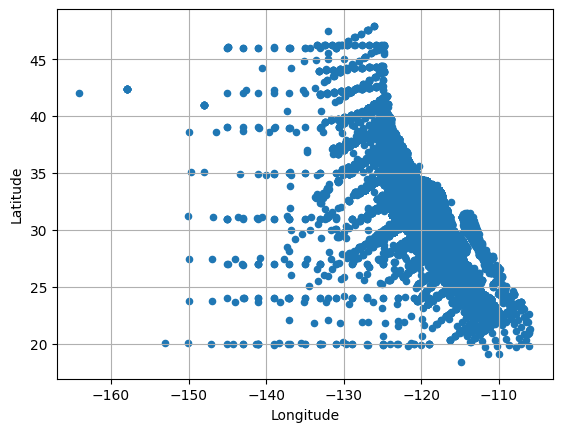

In [109]:
cast_df.plot(kind="scatter", x="Lon_Dec", y="Lat_Dec", grid=True, xlabel='Longitude', ylabel='Latitude')